# **TP Wavelets**

In this TP, we will work on some fundamental concepts in Wavelets and compression of images.

First we'll briefly check the limitations of the Fourier transform. We'll then check some fundamental properties of a family of Wavelets and compute the Wavelet transform of a very simple signal. In the second part of the TP, we will use the DWT to compress and image.

Make sure to sequentially run all the cells in each section, so that the intermediate variables / packages will carry over to the next cell

We recommend you save a copy of this colab in your drive so you don't lose progress!

**Note 1:** As mentioned in the course and since there's not any policy regarding ChatGPT at Télécom level yet, you can use it. However, using ChatGPT without understanding their outputs is not OK, and will be penalized accordingly in your grade. Please be sure of all the functions you'll use.

**Note 2:** Several points have associated questions. When answering these questions, all responses should be properly justified. ChatGPT answers are very easy to spot.

**Note 3:** Always plot the functions and outputs you're generating. If the output or function is not properly plotted/shown, this will reduce points in your grade.

# Setup
First, we install PyWavelets

In [2]:
pip install PyWavelets

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pywt

pywt.__version__

'1.4.1'

# Important
Google Colab is an interesting tool to try things out quickly. However, Google Colab and more general Notebooks are not meant to be an Integrated Development Environment (IDE). For a real job, please use an actual IDE like PyCharm or VS Code.

# Limitation of the Fourier Transform
*   Create a sinusoidal signal of 2.5 seconds of duration.
*   Set up a sampling rate of 20kHz. The signal should be divided in 5 parts of 0.5 seconds of duration each.
*  The signal should have the following frequencies in this order {10 Hz, 30 Hz, 60 Hz, 30 Hz, 10 Hz}.

In [4]:
import numpy as np

time = 2.5
fs = 20000
frequencies = [10, 30, 60, 30, 10]

t = np.arange(0, time, 1/fs)
signal = np.concatenate([np.sin(2*np.pi*f*t[:int(0.5*fs)]) for f in frequencies])

In [5]:
import matplotlib
import matplotlib.pyplot as plt

font_size = 20

plt.figure(figsize=(18, 6))

plt.plot(t, signal, linewidth=1.5)
plt.title('Signal with Changing Discrete Frequencies', fontsize=font_size)
plt.xlabel('Time (s)', fontsize=font_size-1)
plt.ylabel('Amplitude', fontsize=font_size-1)
plt.grid(alpha=0.2)

Now, you should compute the Discrete Fourier Transform of the signal. You can use any library from Python you prefer. You might need to cut the x-axis in the Fourier transform up to 100 Hz in the visualization. Please check https://numpy.org/doc/stable/reference/generated/numpy.fft.fft.html and https://numpy.org/doc/stable/reference/generated/numpy.fft.fftfreq.html

In [6]:
fft = np.fft.fft(signal)
fftfreq = np.fft.fftfreq(len(t), 1/fs)

fftfreq_positive = fftfreq[:len(fftfreq)//2]
fft_positive = np.abs(fft[:len(fftfreq)//2])

plt.figure(figsize=(12, 6))
plt.plot(fftfreq_positive, fft_positive, linewidth=1.5)
plt.title('Discrete Fourier Transform of the Signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.xlim(0, 100)
plt.grid(True)
plt.show()

**QUESTIONS**

1) Does the established sampling rate satisfy the Nyquist-Shannon sampling theorem to avoid aliasing? Please justify.

2) What can you say from the signal looking **only** at the Fourier transform?

3) Can you be certain about the location of some frequency component in the time domain? Why?

**YOUR ANSWERS HERE:**

1) The Nyquist-Shannon sampling theorem states that to avoid aliasing, the sampling rate must be at least twice the maximum frequency present in the signal. Here, the highest frequency is 60 Hz. Therefore, the sampling rate should be at least 2 * 60 Hz = 120 Hz to avoid aliasing. But sampling rate is 20 kHz so it well satisfies the Nyquist-Shannon sampling theorem.

2) We can see 3 peaks at 3 frequencies, with two peaks stronger than the other. Therefore, there are 2 patterns that will repeat.

3) We can be certain about the location of some frequency component in the time domain because the minimal distance between 2 frequencies is 20 Hz and we know that each segment is 0.5 second long. Therefore, the width of the main lobes is 4 Hz and each lobe is separated by at least 18 Hz. The lobes cannot overlap so we can be certain about their position.

# **Mother Wavelet**
As we saw in the course, a wavelet is not just a function but a whole family of functions that satisfy certain requirements. In this part of the TP we're gonna work with the Morlet wavelet defined as follows: $\Psi(t)=k e^{iw_0t}e^{-\frac{1}{2}(\frac{t}{\sigma})^2}$. Please generate a Morlet wavelet in Python **WITHOUT using PyWavelets** with the following parameters:

-Center frequency of the wavelet = 10 Hz

-Sampling rate $\eta$ = 20000 Hz

-$k=\frac{1}{\sqrt{\eta}}$

-$\sigma = 0.1$

You can generate the wavelet between -1 and 1 seconds, so the time duration of the wavelet is 2 seconds. For this part, you just need to generate the real part of the wavelet.

Text(0, 0.5, 'Amplitude')

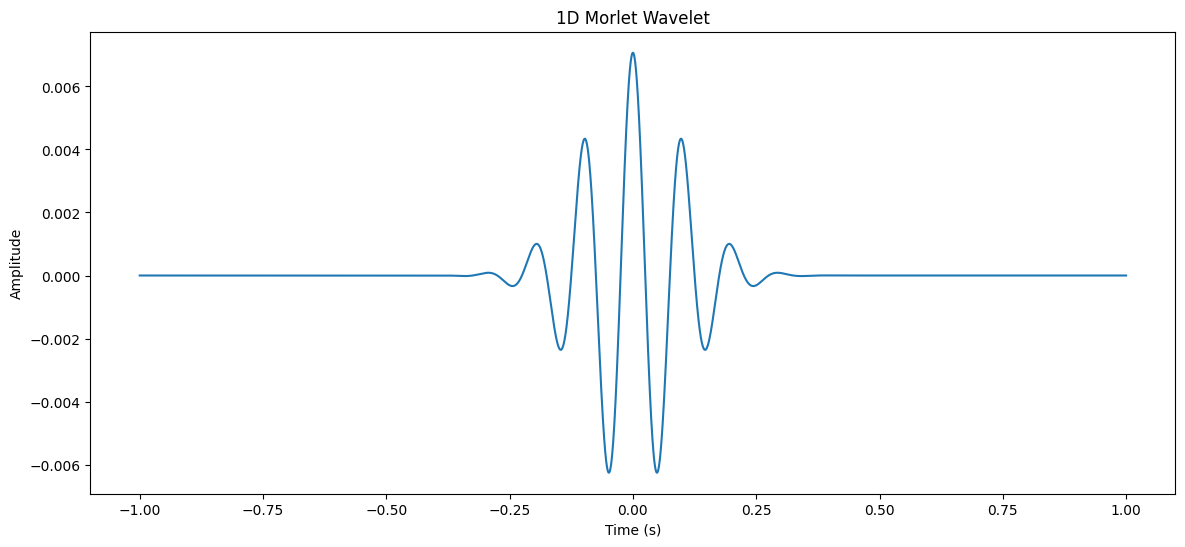

In [7]:
center_frequency = 10
sampling_rate = 20000
k = 1/np.sqrt(sampling_rate)
sigma = 0.1

t = np.arange(-1,1,1/sampling_rate)

OneD_morlet_wavelet = k*np.exp(2j*np.pi*center_frequency*t)*np.exp(-0.5*(t/sigma)**2)

# Plot
plt.figure(figsize=(14, 6))
plt.plot(t, OneD_morlet_wavelet.real, linewidth=1.5)
plt.title('1D Morlet Wavelet')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

Please show that the mother wavelet we just created satisfies the admissibility and the finite energy conditions:

In [8]:
# Calculate the sum of squared absolute values to check admissibility conditions
sum_squared_abs = np.sum(np.abs(OneD_morlet_wavelet)**2)
if np.isfinite(sum_squared_abs):
    print("Admissibility Condition is satisfied.")
else:
    print("Admissibility Condition is not satisfied.")


# Calculate the sum of squared values to check finite energy conditions
sum_squared = np.sum(np.real(OneD_morlet_wavelet)**2)
if np.isfinite(sum_squared):
    print("Finite Energy Condition is satisfied.")
else:
    print("Finite Energy Condition is not satisfied.")

Admissibility Condition is satisfied.
Finite Energy Condition is satisfied.


**Note:** In real life, you have to deal with finite-precision related problems. Therefore, if for the admissibility condition you don't have exactly the value you were expecting for, don't worry.

# **Convolution**

As we saw in the course, we need a measure of similarity to compute the wavelet transform. We also saw that we can easily compute the shift in time and similarity calculation with the 1-D convolutions.

* Generate a chirp sinusoidal signal from -5 to 5 seconds with an initial frequency of 5 Hz and final frequency of 15 Hz and sampling rate of 20kHz:

Text(0.5, 0, 'Time')

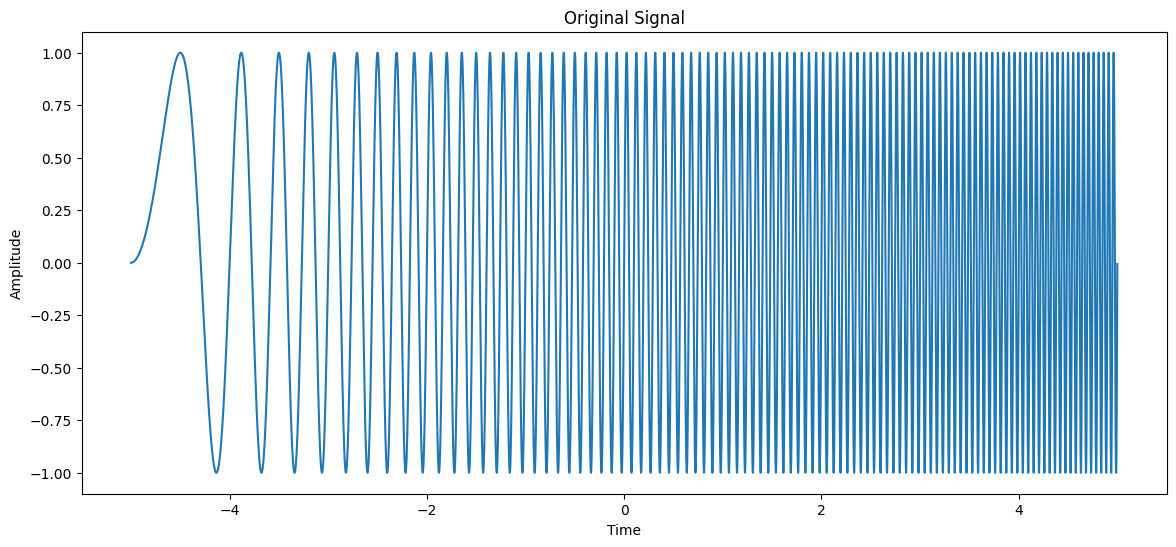

In [9]:
import scipy

time_signal = np.arange(-5,5,1/20000)
def f(t):
  f=10+t
  return np.sin(2*np.pi*f*t)

signal = [f(t) for t in time_signal]

plt.figure(figsize=(14, 6))
plt.plot(time_signal, signal)
plt.title('Original Signal')
plt.ylabel('Amplitude')
plt.xlabel('Time')

Now create a Morlet wavelet with the following parameters:

* Center frequency of the wavelet = 10 Hz

* Sampling rate $\eta$ = 20000 Hz

* $k=\frac{1}{\sqrt{\eta}}$
* $\sigma = 0.2$

Text(0.5, 0, 'Time')

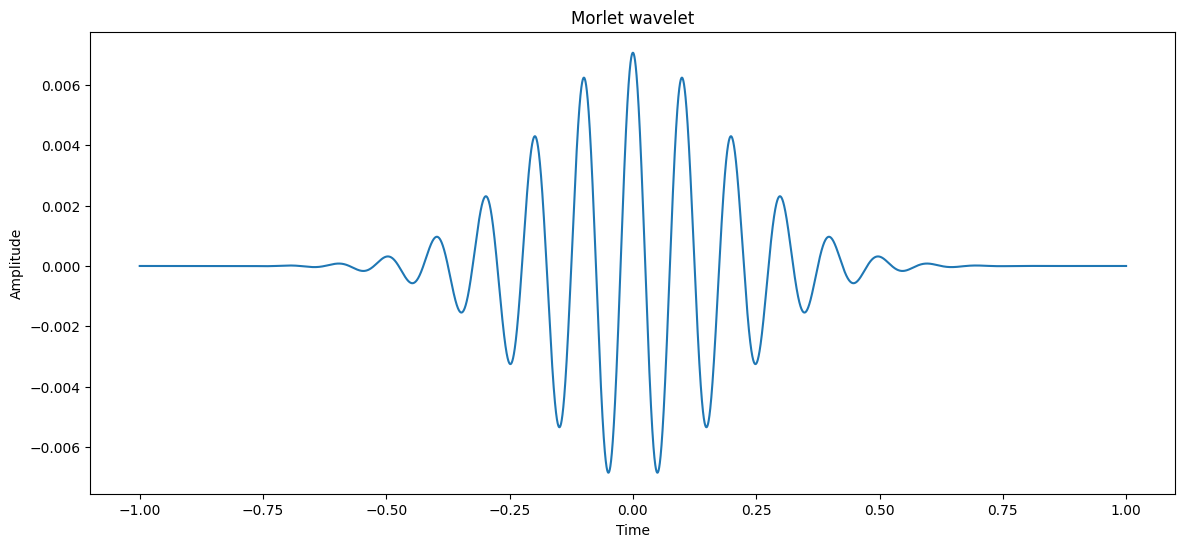

In [10]:
center_frequency = 10
sampling_rate = 20000
k = 1/np.sqrt(sampling_rate)
sigma = 0.2

t = np.arange(-1,1,1/sampling_rate)

morlet_wavelet = k*np.exp(2j*np.pi*center_frequency*t)*np.exp(-0.5*(t/sigma)**2)

plt.figure(figsize=(14, 6))
plt.plot(t, morlet_wavelet.real, linewidth=1.5)
plt.title('Morlet wavelet')
plt.ylabel('Amplitude')
plt.xlabel('Time')

Compute the convolution between the Morlet wavelet and $Re(\Psi(t))$. For reference on how to perform convolution with scipy 'convolve' function, please check https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve.html

C:\Users\Alexandre\AppData\Local\Temp\ipykernel_70732\988012054.py:3: DeprecationWarning: scipy.convolve is deprecated and will be removed in SciPy 2.0.0, use numpy.convolve instead
  convolved_signal = convolve(OneD_morlet_wavelet.real, signal, mode='same')


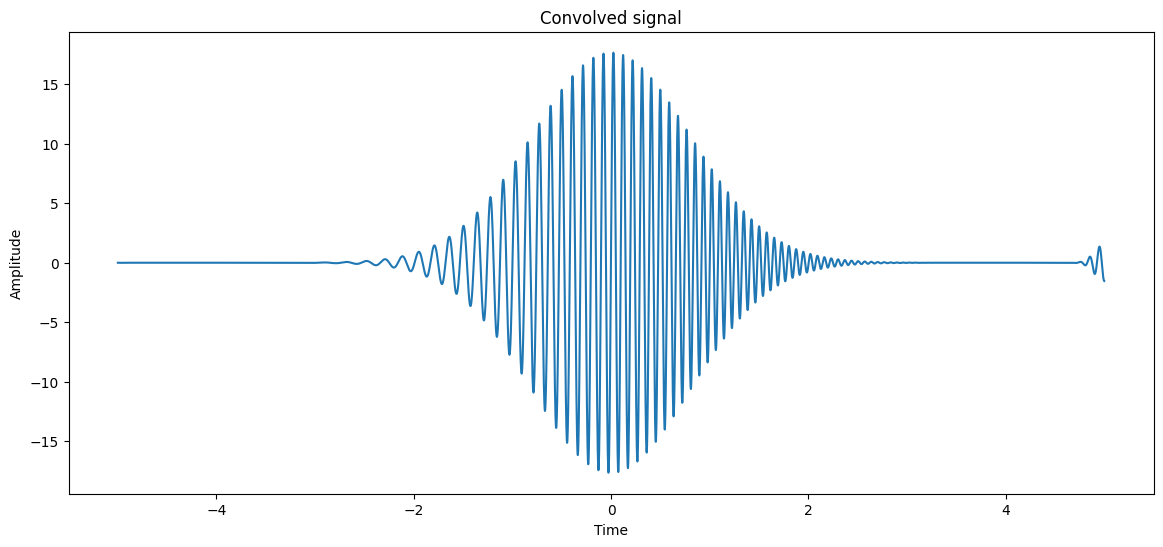

In [11]:
from scipy import convolve

convolved_signal = convolve(OneD_morlet_wavelet.real, signal, mode='same')

# Plot the convolved signal
plt.figure(figsize=(14, 6))
plt.plot(time_signal, convolved_signal)
plt.title('Convolved signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

There are some points where the convolution is zero, even in regions of high similarity between the wavelet and the signal. **Is this OK?** If it's not, propose a solution to that.

C:\Users\Alexandre\AppData\Local\Temp\ipykernel_70732\3501905350.py:3: DeprecationWarning: scipy.convolve is deprecated and will be removed in SciPy 2.0.0, use numpy.convolve instead
  convolved_signal = scipy.convolve(morlet_wavelet, signal, mode='same')


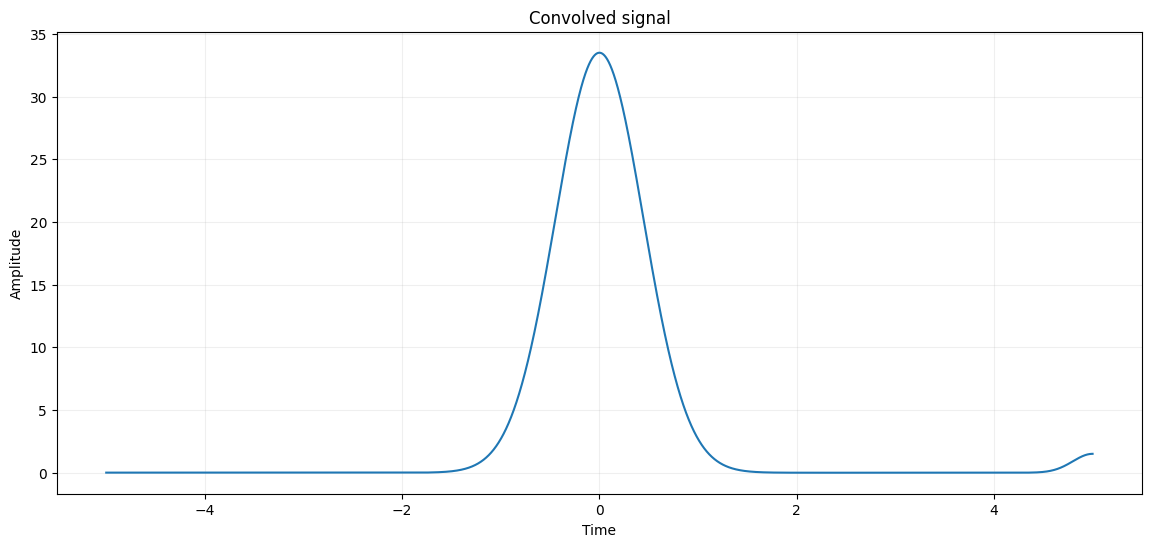

In [36]:
import scipy.signal 

convolved_signal = scipy.convolve(morlet_wavelet, signal, mode='same')
plt.figure(figsize=(14, 6))
plt.plot(time_signal, abs(convolved_signal))
plt.title('Convolved signal')
plt.ylabel('Amplitude')
plt.xlabel('Time')
plt.grid(alpha=0.2)


# **Image Compression**
For this part, we'll use the Discrete Wavelet Transform (DWT) implemented as a filter bank to do image compression. The first step is to have an image to compress. For doing so you can use the following piece of code to download an image of Trudy.

In [15]:
!curl -O https://raw.githubusercontent.com/jhonygiraldo/jhonygiraldo.github.io/main/Trudy_for_compression.jpeg


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
 67  544k   67  367k    0     0   358k      0  0:00:01  0:00:01 --:--:--  358k
100  544k  100  544k    0     0   433k      0  0:00:01  0:00:01 --:--:--  433k


**Visualize image:** With the following code you can visualize the image. If you're using Google Collab, most probably you already have the open cv library installed. If you're using Jupyter Notebook for example, you'll have to install open cv if it's not already installed.

In [16]:
# Let us define a function for visualizing images
def show_image(image, title='Input Image', font_size=12,fig_size = (10, 10)):
  #A function that uses matplotlib to show grayscale images
  plt.figure(figsize=fig_size)
  plt.imshow(image, cmap='gray')
  plt.title(title, fontsize=font_size)
  plt.axis('off')

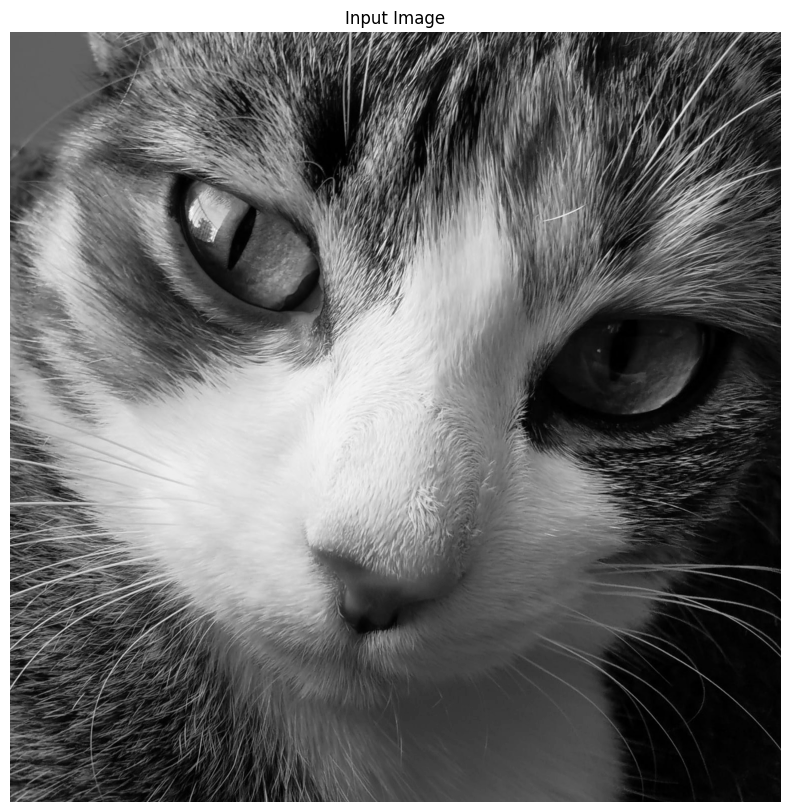

In [17]:
import cv2

input_image = cv2.imread('Trudy_for_compression.jpeg', cv2.IMREAD_GRAYSCALE)

# Convert the image data type
if input_image.dtype == 'uint8':
    input_image = input_image.astype('float32') / 255.0  # Convert to float in the range [0, 1]

# Display the original image
show_image(input_image, 'Input Image')


If you use some wavelet function (Biorthogonal 1.3 in this case), the 1-level 2D wavelet decomposition of our input image is given as follows:

In [18]:
# # You can see a list of wavelet families
import pywt
pywt.families()

['haar',
 'db',
 'sym',
 'coif',
 'bior',
 'rbio',
 'dmey',
 'gaus',
 'mexh',
 'morl',
 'cgau',
 'shan',
 'fbsp',
 'cmor']

In [19]:
# For each family, you can list the available wavelets
pywt.wavelist(family='bior', kind='all')

['bior1.1',
 'bior1.3',
 'bior1.5',
 'bior2.2',
 'bior2.4',
 'bior2.6',
 'bior2.8',
 'bior3.1',
 'bior3.3',
 'bior3.5',
 'bior3.7',
 'bior3.9',
 'bior4.4',
 'bior5.5',
 'bior6.8']

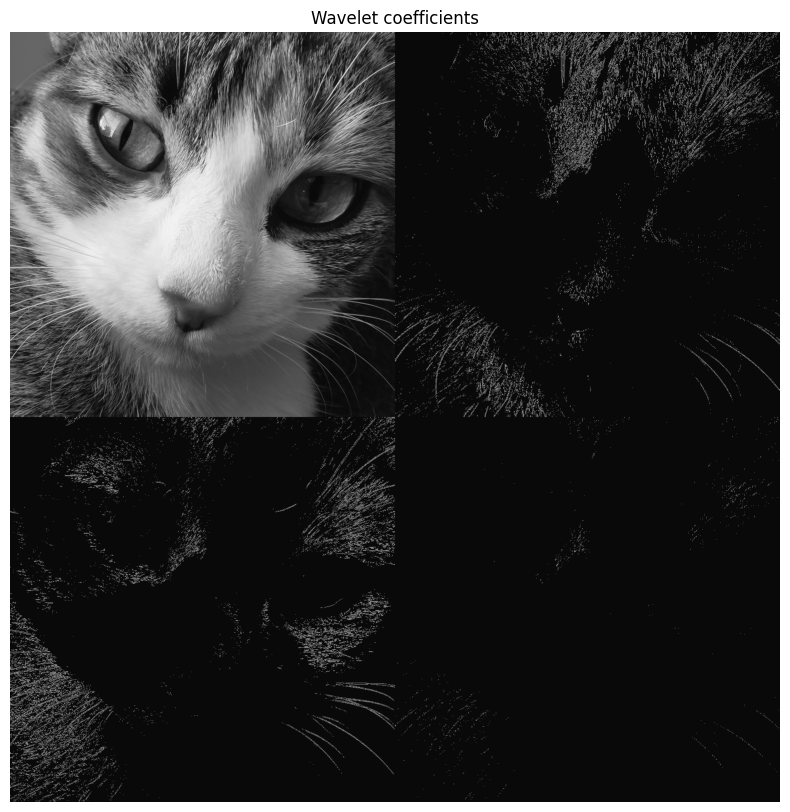

In the previous image we applied a threshold in the wavelet coefficients for visualization purposes. **Please explain the meaning of each of these 4 images**.

**YOUR ANSWER HERE:**

1) Input Image: This is the original image of Trudy. It serves as the baseline for the compression process.

2) Wavelet Coefficients Image: This image represents the coefficients obtained after applying the Discrete Wavelet Transform (DWT) to the original image. The DWT decomposes the image into different frequency components, capturing both high and low-frequency information.

3) Thresholded Coefficients Image: To visualize the impact of thresholding on compression, certain coefficients obtained from the DWT are set to zero. This is done by applying a threshold to the wavelet coefficients. By discarding less significant coefficients, we can reduce the amount of data needed to represent the image.

4) Reconstructed Image: This is the image reconstructed from the thresholded wavelet coefficients. After setting some coefficients to zero and applying the inverse DWT, we get an approximation of the original image. The quality of the reconstruction depends on the thresholding strategy and the chosen wavelet.


Now, you should compute the six-levels 2D wavelet decomposition of the input image with a Daubechies wavelet with six vanishing moments using the PyWavelet library. Please check https://pywavelets.readthedocs.io/en/latest/ref/2d-dwt-and-idwt.html#d-multilevel-decomposition-using-wavedec2

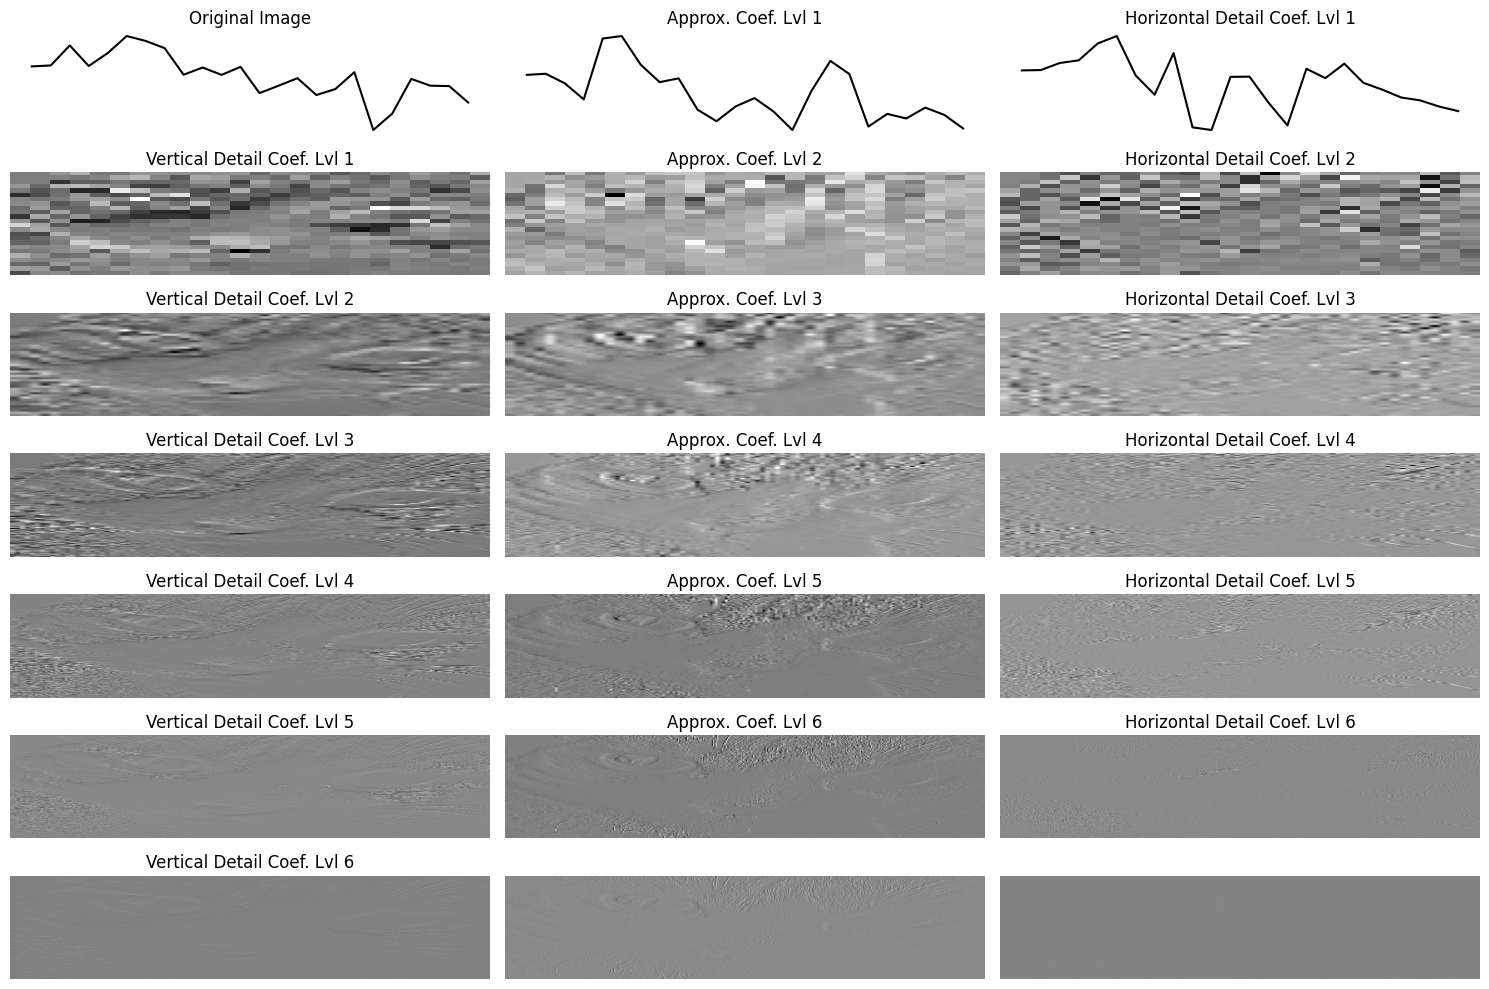

In [20]:
import pywt
import cv2
import matplotlib.pyplot as plt

input_image = cv2.imread('Trudy_for_compression.jpeg', cv2.IMREAD_GRAYSCALE)
wavelet = 'db1'  # Daubechies wavelet with 1 vanishing moment 
levels = 6

coeffs = pywt.wavedec2(input_image, wavelet, level=levels)

titles = ['Original Image']
for i in range(1, levels + 1):
    titles.extend([f'Approx. Coef. Lvl {i}', f'Horizontal Detail Coef. Lvl {i}', f'Vertical Detail Coef. Lvl {i}'])

expected_titles_length = (levels + 1) * 3
while len(titles) < expected_titles_length:
    titles.append('')

plt.figure(figsize=(15, 10))
for i, coeff in enumerate(coeffs):
    for j in range(3):  # Display each component separately
        plt.subplot(levels + 1, 3, i * 3 + j + 1)
        
        # Check dimensionality and plot accordingly
        if len(coeff[j].shape) == 1:
            plt.plot(coeff[j], color='black')
            plt.title(titles[i * 3 + j])
            plt.axis('off')
        else:
            plt.imshow(coeff[j], cmap='gray', aspect='auto')
            plt.title(titles[i * 3 + j])
            plt.axis('off')

plt.tight_layout()
plt.show()



* Set a threshold of value of 100 and take to zero the values less than that in the 2D wavelet decomposition. **Note:** You should only threshold the outputs of the high-pass filters.



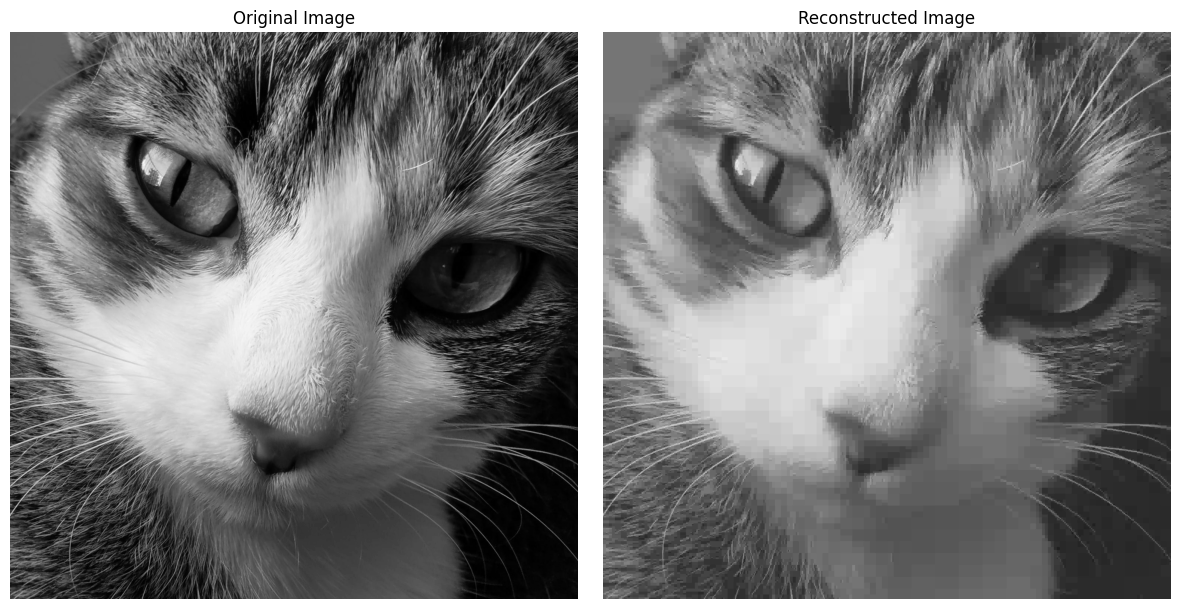

In [21]:
# Set a threshold value
threshold_value = 100

# Threshold the high-pass filter coefficients
for i in range(1, levels + 1):
    coeffs[i] = tuple(
        map(lambda x: np.where(np.abs(x) < threshold_value, 0, x), coeffs[i])
    )

# Reconstruct the image using the modified coefficients
reconstructed_image = pywt.waverec2(coeffs, wavelet)
cv2.imwrite('compressed_image.jpeg', reconstructed_image)

# Visualize the original and reconstructed images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(input_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image, cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')

plt.tight_layout()
plt.show()


* Compute the IDWT to reconstruct the image after the "compression". Check https://pywavelets.readthedocs.io/en/latest/ref/2d-dwt-and-idwt.html#d-multilevel-reconstruction-using-waverec2 as a reference.

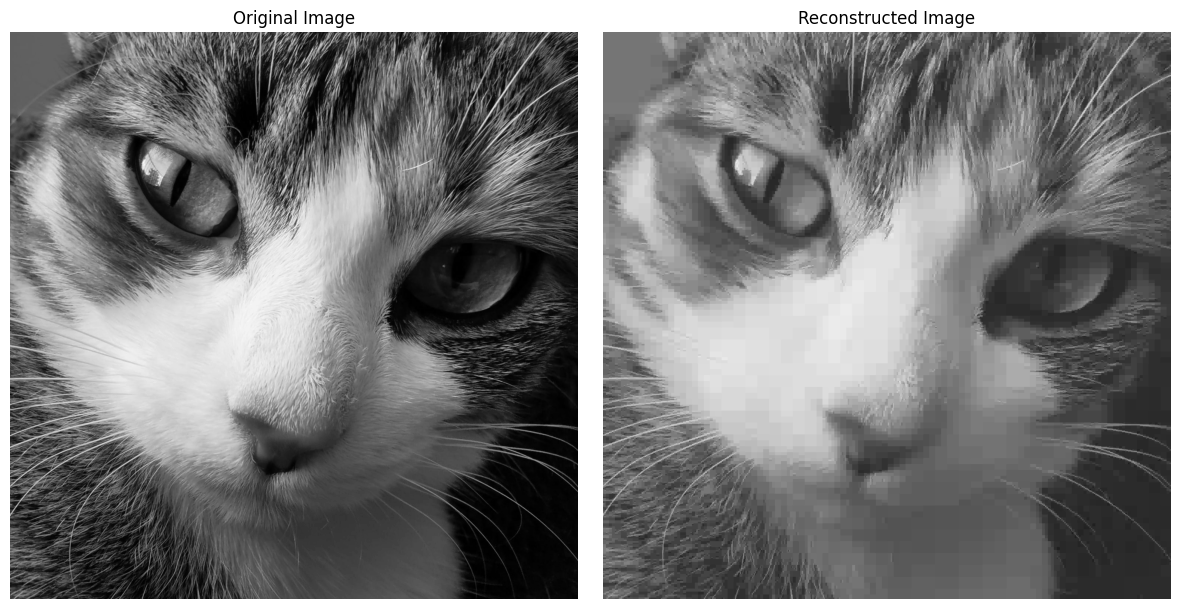

In [22]:
# Reconstruct the image using the modified coefficients
reconstructed_image = pywt.waverec2(coeffs, wavelet)

# Visualize the original and reconstructed images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(input_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image, cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')

plt.tight_layout()
plt.show()


What's the compression ratio?

In [23]:
import os

original_size = os.path.getsize('Trudy_for_compression.jpeg')  
compressed_size = os.path.getsize('compressed_image.jpeg') 
compression_ratio = original_size / compressed_size

print(f"Original Size: {original_size} bytes")
print(f"Compressed Size: {compressed_size} bytes")
print(f"Compression Ratio: {compression_ratio:.2f}")


Original Size: 557430 bytes
Compressed Size: 241504 bytes
Compression Ratio: 2.31


# **Putting everything together**

In this exercise we'll analyze the Peak Signal to Noise Ration (PSNR) of the compressed images for different thresholds. For doing so, we'll give you the function to compute the PSNR between the original and compressed image.

In [28]:
def psnr(original_image, compressed_image):
    h,w = original_image.shape
    mse = np.sum(np.abs(original_image-compressed_image)**2)/(h*w)
    return 20* np.log10(255**2/mse)

Now, you have to create a function codec that receives the input image, the wavelet to be used, the number of levels, and the threshold value. This function returns the compressed image and the compression ratio. **Note:** You already did that previously.

In [33]:
def codec(input_image, wavelet='db4', num_levels=6, threshold=100):
    c = pywt.wavedec2(input_image, wavelet=wavelet, level=num_levels)
    
    for i in range(1, num_levels + 1):
        for j in range(3):
            for k in range(len(c[i][j])):
                for l in range(len(c[i][j][k])):
                    if abs(c[i][j][k][l]) <= threshold:
                        c[i][j][k][l] = 0
    
    compressed_image = pywt.waverec2(c, wavelet)
    compressed_image = compressed_image[:len(input_image), :len(input_image[0])]
    
    n_pixel = len(compressed_image) * len(compressed_image[0])
    n_zero = np.sum(compressed_image == 0)
    
    return compressed_image, n_pixel / (n_pixel - n_zero)


Now, we compare the performance of the 'db4' and the 'bior1.3' wavelets in terms of compression ratio and PSNR for different thresholds.

In [34]:
wavelet_1 = 'db4'
wavelet_2 = 'bior1.3'
w=[wavelet_1,wavelet_2]
thresholds = [5,10,20,40,80,100]
num_levels=6

# Your code here
for threshold in thresholds:
    print("For the threshold = "+str(threshold))
    for wavelet in w:
        print("For the wavelet : " + wavelet)
        a=codec(input_image,wavelet,num_levels,threshold)
        ratio=a[1]
        compressed=a[0]
        print("Ratio = " + str(ratio) +", and PNSR = " +str(psnr(compressed,input_image)))
    


For the threshold = 5
For the wavelet : db4
Ratio = 1.0, and PNSR = 89.14376053205345
For the wavelet : bior1.3
Ratio = 1.0, and PNSR = 88.69800951802364
For the threshold = 10
For the wavelet : db4
Ratio = 1.0, and PNSR = 78.55761457092545
For the wavelet : bior1.3
Ratio = 1.0, and PNSR = 77.2400416971573
For the threshold = 20
For the wavelet : db4
Ratio = 1.0, and PNSR = 68.88789568218358
For the wavelet : bior1.3
Ratio = 1.0, and PNSR = 66.99546228753876
For the threshold = 40
For the wavelet : db4
Ratio = 1.0, and PNSR = 60.6998532271033
For the wavelet : bior1.3
Ratio = 1.0, and PNSR = 58.05949780192971
For the threshold = 80
For the wavelet : db4
Ratio = 1.0, and PNSR = 53.87961999605656
For the wavelet : bior1.3
Ratio = 1.0, and PNSR = 51.464561940976466
For the threshold = 100
For the wavelet : db4
Ratio = 1.0, and PNSR = 51.780200834500825
For the wavelet : bior1.3
Ratio = 1.0, and PNSR = 49.808328581522865


**QUESTIONS**

1) Which wavelet is better for the Trudy_for_compression.jpeg image and why?


**Answer**

It seems that the 'db4' wavelet performs slightly better than 'bior1.3' in terms of PSNR for various threshold values. (A higher PSNR indicates better image quality.)

For the Trudy_for_compression.jpeg image, the 'db4' wavelet might be more suitable due to its ability to capture important features while suppressing noise effectively. The higher PSNR values suggest that the reconstructed image using 'db4' wavelet retains more information and is closer to the original image compared to the 'bior1.3' wavelet.

# Supplementary Exercises (Optional)
1. Designing and using custom filters with the pyWavelets library
Reference (https://pywavelets.readthedocs.io/en/latest/ref/wavelets.html#wavelet-families)
2. Propose and explore custom wavelets that achieve equivalent or higher compression ratio on the Trudy image explored previously. **P.S** You are free to explore any approach here.